In [ ]:
# 模拟生成时间序列
# 模拟生成数据集
# 搭建两个RNN神经网络，一个使用LR_scheduler机制调整学习率，另一个不做处理
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%203%20Lesson%202%20-%20RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

In [ ]:
# 模拟生成时间序列
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")  #1461
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
# 模拟生成数据集
#参数说明： 序列数据（一维数组），窗口大小，批次大小，随机缓存大小
#输出： (特征， 标签)
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
  return dataset

# pytorch

In [ ]:
# 搭建SimpleRNN神经网络，使用LR_scheduler机制调整学习率
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)
#神经网络的搭建
model = tf.keras.models.Sequential([
    #匿名层：处理输入参数，将输入
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),  # tf.expand_dims(x,axis=-1) x是input,-1代表最后一维，对应y=时间序列
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),#RNN单元数量为40，返回输出序列中的完整序列
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1), #神经元个数为1
  tf.keras.layers.Lambda(lambda x: x * 100.0)#x的规则
])
#运用lrscheduler来进行学习率的调节 epoch=10的-8次 * 10^(epoch/20)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
#SGD随机梯度下降，lr=学习率，momentum：动量参数
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
#model.compile()方法用于在配置训练方法时候，告知训练时所用的优化器、损失函数和准确率评测
model.compile(loss=tf.keras.losses.Huber(),#损失函数
              optimizer=optimizer,#优化器
              metrics=["mae"])#准确率评判
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
# 搭建SimpleRNN神经网络，不调整学习率
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])
#在需要将隐层的结果作为下一层的输入时，选择return_sequences=True

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=100)

Epoch 1/100
8/8 [==============================] - 0s 6ms/step - loss: 81.7535 - mae: 82.2534
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 21.9357 - mae: 22.4301
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 15.9201 - mae: 16.4144
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 12.2878 - mae: 12.7813
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 10.1496 - mae: 10.6398
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 16.3675 - mae: 16.8627
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 13.2591 - mae: 13.7505
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - loss: 9.0446 - mae: 9.5349
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 7.8271 - mae: 8.3149
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 9.7639 - mae: 10.2559
Epoch 11/100
8/8 [==============================] - 0s 8ms/step 

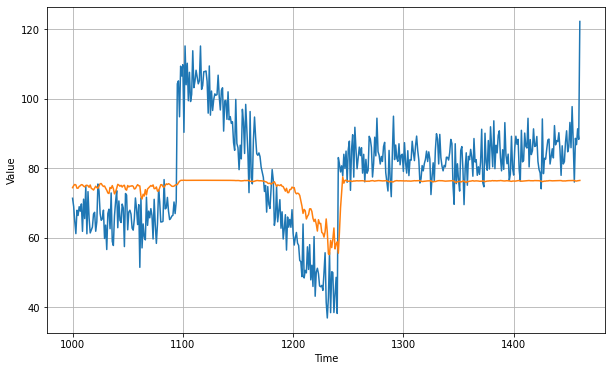

In [9]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
# 结果对比，计算误差loss和平均绝对误差MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

10.65494

<Figure size 432x288 with 0 Axes>

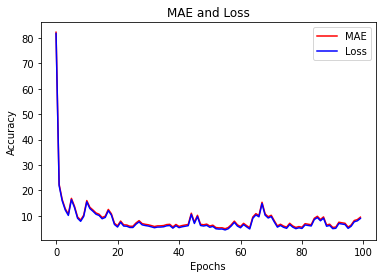

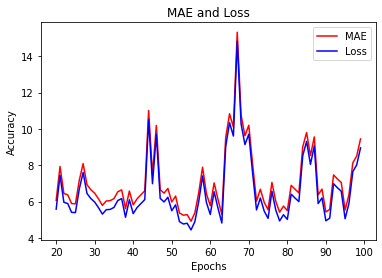

<Figure size 432x288 with 0 Axes>

In [16]:
# 从训练集和测试集上获取结果列表
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(ehs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[20:]
mae_zoom = mae[20:]
loss_zoom = loss[20:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()
